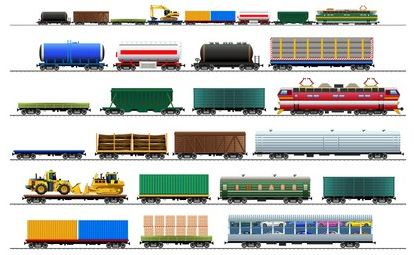

<h1 align="center">(НИИАС/РЖД) Прогнозирование зарождающегося вагонопотока (отправления вагонов)</h1>

<h2 align="center">Команда 3 - "Machine earning"</h2>

In [1]:
import pandas as pd
from datetime import datetime, date, time

# Берем новый датасет от 22 мая 2021
df = pd.read_csv('ssp_stat_load_car-94-96.csv', sep = ';')
df.head()

,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,...,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id
0,20,58461757,NaN,911605.0,2.000036e+09,0.0,161062.0,2310798267707,9.676001e+14,NaN,...,7.207974e+11,797123463,0.0,1666.0,0.0,0,96,0.0,0.0,2096ЭЦ664940
1,20,58363474,NaN,911605.0,2.000036e+09,0.0,161062.0,2310798267704,9.676001e+14,NaN,...,7.207974e+11,797123463,0.0,1666.0,0.0,0,96,0.0,0.0,2096ЭЦ664866
2,20,58375296,NaN,911605.0,2.000036e+09,0.0,161062.0,2310798267706,9.676001e+14,NaN,...,7.207974e+11,797123463,0.0,1666.0,0.0,0,96,0.0,0.0,2096ЭЦ690043
3,20,60115441,NaN,862108.0,2.001931e+09,0.0,161062.0,2310798267711,9.676001e+14,NaN,...,7.207974e+11,797123463,0.0,1666.0,0.0,0,96,0.0,0.0,2096ЭЦ774793
4,20,59448522,NaN,864902.0,2.000040e+09,0.0,161062.0,2310798267708,9.676001e+14,NaN,...,7.207974e+11,797123463,0.0,1666.0,0.0,0,96,0.0,0.0,2096ЭЦ731745


In [2]:
print(f'Начало периода: {df.operation_date.min()}')
print(f'Конец периода: {df.operation_date.max()}')

Начало периода: 2021-03-16 00:01:00
Конец периода: 2021-05-20 05:51:00


In [3]:
# В operation_train много пропусков, но далее после фильтрации видно, что эти строки отфильтруются (можно не сбрасывать)

df.isnull().sum()

adm                       0
car_number                0
danger              1452932
destination_esr        1718
destination_id         1718
group_car            971562
gruz                 753979
id                        0
index_train          789265
innovag              992077
int_disl                  0
kds                       0
kod_group            971562
length                    0
loaded                    0
lves                1501134
number_train         906538
ont_time_write            0
operation_car             0
operation_date            0
operation_st_esr          0
operation_st_id           0
operation_train      789265
operator                  0
park                 342045
receiver             753859
rodvag                    0
rod_train            906432
sender               753859
ssp_station_esr      789265
ssp_station_id       789580
stkgos_id           1485220
tare_weight               0
track                342045
train_id             906067
uns                 

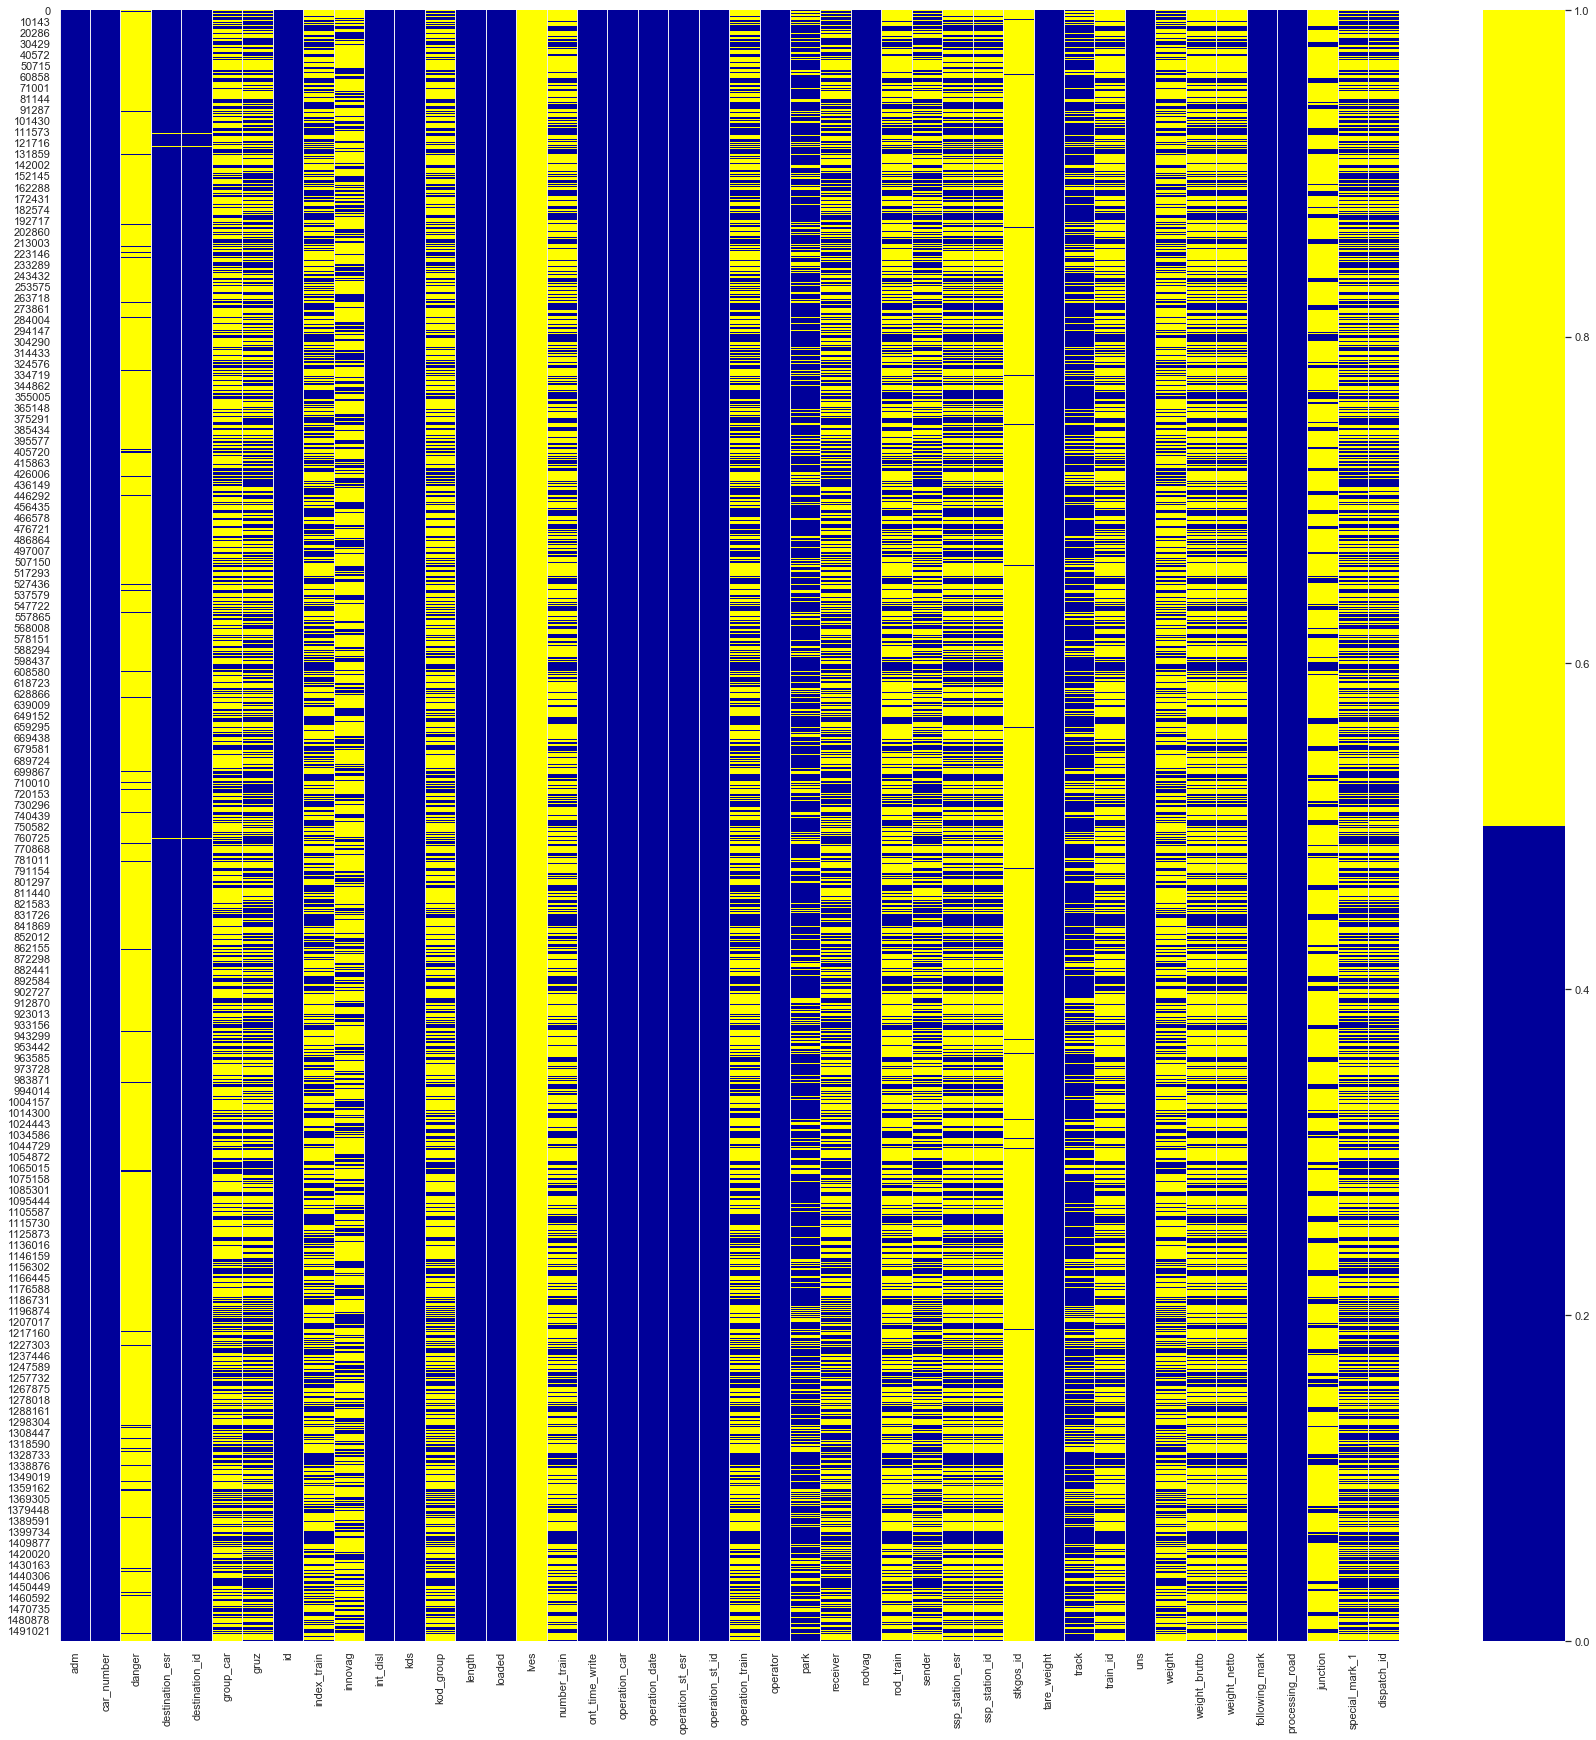

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(30, 30)})

cols = df.columns[:] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [5]:
len(df)

1501134

In [6]:
# Дубликатов нет, но они тоже отфильтровались бы далее

df.drop_duplicates(inplace=True)
len(df)

1501134

In [7]:
wagons = df

In [8]:
%%time

# Функция для выбора строк с вагонами, которые были последовательно загружены/выгружены, включены в поезд и отправлены

def filter_needed_wagon_operations(wagons, include_op_code, load_op_code):
    # Оставляем только нужные операции
    wagons = wagons.loc[(wagons['operation_car'].isin(include_op_code)) | 
                        (wagons['operation_car'].isin(load_op_code)) | 
                        (wagons['operation_train'] == 2)]
    
    # Сортируем по станции, вагону и дате
    wagons.sort_values(by=['operation_st_esr', 'car_number', 'operation_date'], ascending=False, inplace=True)
    
    wagons_clean = []
    departure_indicator = 0
    
    # Отбираем только те записи, где отправке и включению в поезд предшествует загрузка/выгрузка
    for idx, operation in wagons.iterrows():
        if operation.loc['operation_train'] == 2:
            departure_indicator = 1
            included_indicator = 0
            current_wagon = operation.car_number
        elif operation.loc['operation_car'] in include_op_code and departure_indicator == 1 and included_indicator == 0 and current_wagon == operation.car_number:
            chosen_operation = operation.tolist()
            included_indicator = 1
        elif operation.loc['operation_car'] in load_op_code and included_indicator == 1 and current_wagon == operation.car_number:
            wagons_clean.append(chosen_operation)
            included_indicator, departure_indicator = 0, 0 
        else:
            pass
        
    wagons_clean_df = pd.DataFrame(wagons_clean, columns = wagons.columns)
    
    return wagons_clean_df

# Списки кодов операций для включения в поезд и загрузки\выгрузки 
include_op_code = [4]
load_op_code = [10, 11, 18, 19, 34, 20, 21, 28, 29, 44]

wagon_clean = filter_needed_wagon_operations(wagons, include_op_code, load_op_code)
wagon_clean.head(10)

C:\Users\vagary\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Wall time: 3min 10s


,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,...,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id
0,20,92676071,NaN,989309.0,2.000039e+09,NaN,81046.0,2450799917057,9.687073e+14,NaN,...,7.507936e+11,855942307,NaN,5564.0,3935.0,0,96,NaN,0.0,209630643837
1,20,92675552,NaN,967808.0,2.000039e+09,NaN,81188.0,2350793885625,9.687073e+14,NaN,...,7.307948e+11,812051455,NaN,5619.0,3963.0,0,96,NaN,0.0,2096ЭЧ423237
2,20,92675388,NaN,989309.0,2.000039e+09,NaN,81046.0,2550797885797,9.687075e+14,NaN,...,7.607994e+11,897014113,NaN,5565.0,3780.0,0,96,NaN,0.0,209630801508
3,20,92674787,NaN,989309.0,2.000039e+09,NaN,81046.0,2550797885792,9.687075e+14,NaN,...,7.607994e+11,897014113,NaN,5565.0,3780.0,0,96,NaN,0.0,209630801427
4,20,92673987,NaN,989309.0,2.000039e+09,NaN,81188.0,2460798221429,9.687074e+14,NaN,...,7.507945e+11,858101371,NaN,5560.0,3916.0,0,96,NaN,0.0,209630673208
5,20,92673524,NaN,989309.0,2.000039e+09,NaN,81046.0,2540797496112,9.687074e+14,NaN,...,7.607976e+11,892245573,NaN,5525.0,3698.0,0,96,NaN,0.0,209630806915
6,20,92673086,NaN,989309.0,2.000039e+09,NaN,81188.0,2460798221397,9.687074e+14,NaN,...,7.507945e+11,858101371,NaN,5560.0,3916.0,0,96,NaN,0.0,209630647302
7,20,92672039,NaN,989309.0,2.000039e+09,NaN,81188.0,2470791981212,9.687074e+14,NaN,...,7.507953e+11,859996796,NaN,5550.0,3870.0,0,96,NaN,0.0,209630656573
8,20,92670900,NaN,989309.0,2.000039e+09,NaN,81046.0,2550797885728,9.687075e+14,NaN,...,7.607994e+11,897014113,NaN,5565.0,3780.0,0,96,NaN,0.0,209630796249
9,20,92670348,NaN,989309.0,2.000039e+09,NaN,81046.0,2550797885713,9.687075e+14,NaN,...,7.607994e+11,897014113,NaN,5565.0,3780.0,0,96,NaN,0.0,209630801440


In [9]:
# В нужных нам данных пропусков нет

wagon_clean.isnull().sum()

adm                      0
car_number               0
danger              166424
destination_esr        222
destination_id         222
group_car           166424
gruz                    47
id                       0
index_train              0
innovag             111179
int_disl                 0
kds                      0
kod_group           166424
length                   0
loaded                   0
lves                166424
number_train            31
ont_time_write           0
operation_car            0
operation_date           0
operation_st_esr         0
operation_st_id          0
operation_train          0
operator                 0
park                     0
receiver                 0
rodvag                   0
rod_train               31
sender                   0
ssp_station_esr          0
ssp_station_id         145
stkgos_id           166424
tare_weight              0
track                    0
train_id                 3
uns                      0
weight              166424
w

In [10]:
# Возьмем из index_train последние 6 цифр (пункт назначения поезда)

wagon_clean['index_train']=wagon_clean['index_train'].astype(str)
wagon_clean['index_train'][0]

'968707335960103.0'

In [11]:
wagon_clean['index_train']=wagon_clean['index_train'].apply(lambda x: x[-8:-2]).astype(int) 
wagon_clean['index_train']

0         960103
1         960007
2         960103
3         960103
4         960007
           ...  
166419    940105
166420    940105
166421    940105
166422    940105
166423    940105
Name: index_train, Length: 166424, dtype: int32

In [12]:
# В нашем случае поезда едут по 167 направлениям (по 4-м последним цифрам направлений было 164)

wagon_clean['index_train'].value_counts()

960007    44395
937906    17848
950101    14641
917207     7788
943108     6414
          ...  
942603        1
963506        1
888004        1
947503        1
967009        1
Name: index_train, Length: 167, dtype: int64

In [13]:
# На всякий случай

wagon_clean['operation_date'] = pd.to_datetime(wagon_clean['operation_date'])

In [14]:
# Итоговый сет для группировки

res0 = wagon_clean[['operation_st_esr', 'operation_date', 'index_train']] # без 'car_number' - сами номера не нужны
res0.sort_values(by=['operation_st_esr', 'operation_date'], ascending=True, inplace=True)
res0.head(10)

C:\Users\vagary\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,operation_st_esr,operation_date,index_train
164249,940006,2021-03-16 17:22:00,940105
164488,940006,2021-03-16 17:22:00,940105
164814,940006,2021-03-16 17:22:00,940105
165120,940006,2021-03-16 17:22:00,940105
164567,940006,2021-03-16 20:03:00,943108
162831,940006,2021-03-17 06:10:00,940105
163259,940006,2021-03-17 06:10:00,940105
163628,940006,2021-03-17 06:10:00,940105
163932,940006,2021-03-17 06:10:00,940105
164032,940006,2021-03-17 06:10:00,940105


In [15]:
# Посчитать, сколько вагонов ушло по направлениям по индексу поезда в пределах каждых четырех часов по каждой станции

stations =  res0['operation_st_esr'].unique()
new_data = pd.DataFrame([])

for i in stations:
    dataset_i = res0[res0['operation_st_esr'] == i]
    dataset_i = dataset_i.groupby([pd.Grouper(key="operation_date", freq="4H"), 'index_train']).count()
    
    dataset_i = dataset_i.rename(columns={'operation_st_esr': 'quantity'})
    dataset_i['operation_st_esr'] = i

    new_data = pd.concat([new_data, dataset_i])
    
new_data.head(30)   

quantity  operation_st_esr
operation_date      index_train                            
2021-03-16 16:00:00 940105              4            940006
2021-03-16 20:00:00 943108              1            940006
2021-03-17 04:00:00 940105             13            940006
2021-03-17 08:00:00 943108              6            940006
2021-03-17 16:00:00 940105             48            940006
                    943108             11            940006
2021-03-18 04:00:00 940105             17            940006
2021-03-18 16:00:00 940105             17            940006
2021-03-18 20:00:00 943108             25            940006
2021-03-19 00:00:00 943108              7            940006
2021-03-19 04:00:00 940105             12            940006
2021-03-19 08:00:00 870405             26            940006
                    943108              2            940006
2021-03-19 12:00:00 947005             47            940006
2021-03-19 16:00:00 940105             33            940006
2021-03-19 20:00:00 942105             23            940006
                    943108             12            940006
2021-03-20 04:00:00 940105             12            940006
2021-03-20 08:00:00 940105              1            940006
                    986103              1            940006
2021-03-20 16:00:00 940105             18            940006
2021-03-20 20:00:00 943108              5            940006
2021-03-21 04:00:00 940105             16            940006
2021-03-21 08:00:00 943108             20            940006
2021-03-21 16:00:00 940105             28            940006
                    943108              2            940006
2021-03-22 04:00:00 940105             10            940006
                    943108             25            940006
2021-03-22 08:00:00 943108              9            940006
2021-03-22 16:00:00 940105              3            940006

In [16]:
new_data.reset_index(level=['index_train'], inplace = True)
new_data.head(30)   

,index_train,quantity,operation_st_esr
operation_date,,,
2021-03-16 16:00:00,940105,4,940006
2021-03-16 20:00:00,943108,1,940006
2021-03-17 04:00:00,940105,13,940006
2021-03-17 08:00:00,943108,6,940006
2021-03-17 16:00:00,940105,48,940006
2021-03-17 16:00:00,943108,11,940006
2021-03-18 04:00:00,940105,17,940006
2021-03-18 16:00:00,940105,17,940006
2021-03-18 20:00:00,943108,25,940006


In [17]:
%%time

# Заполним нулями количество вагонов, когда отправок по какому-либо из направлений не было
# Другими словами, заполним пропуски

direction = new_data['index_train'].unique()
st = new_data['operation_st_esr'].unique()
res = pd.DataFrame([])

for i in st:
    for j in direction:
        dataset_i = new_data[(new_data['operation_st_esr'] == i) & (new_data['index_train'] == j )]

        dataset_i1 = dataset_i.resample('4H').first()
        dataset_i1['index_train'] = j
        dataset_i1['operation_st_esr'] = i
     
        res = pd.concat([res, dataset_i1])

res.head(15)

Wall time: 3min 11s


,index_train,quantity,operation_st_esr
operation_date,,,
2021-03-16 16:00:00,940105,4.0,940006
2021-03-16 20:00:00,940105,NaN,940006
2021-03-17 00:00:00,940105,NaN,940006
2021-03-17 04:00:00,940105,13.0,940006
2021-03-17 08:00:00,940105,NaN,940006
2021-03-17 12:00:00,940105,NaN,940006
2021-03-17 16:00:00,940105,48.0,940006
2021-03-17 20:00:00,940105,NaN,940006
2021-03-18 00:00:00,940105,NaN,940006


In [18]:
res.fillna(0, inplace = True)
res.head(15)

,index_train,quantity,operation_st_esr
operation_date,,,
2021-03-16 16:00:00,940105,4.0,940006
2021-03-16 20:00:00,940105,0.0,940006
2021-03-17 00:00:00,940105,0.0,940006
2021-03-17 04:00:00,940105,13.0,940006
2021-03-17 08:00:00,940105,0.0,940006
2021-03-17 12:00:00,940105,0.0,940006
2021-03-17 16:00:00,940105,48.0,940006
2021-03-17 20:00:00,940105,0.0,940006
2021-03-18 00:00:00,940105,0.0,940006


In [19]:
# теперь нужно сформировать пары operation_st_esr - index_train и сделать по ним предсказания

# Возьмем пока что первую пару для предварительных расчетов, далее расширим решение

df940006_940105 = res[((res['index_train'] == 940105) & (res['operation_st_esr'] == 940006))]
df940006_940105

,index_train,quantity,operation_st_esr
operation_date,,,
2021-03-16 16:00:00,940105,4.0,940006
2021-03-16 20:00:00,940105,0.0,940006
2021-03-17 00:00:00,940105,0.0,940006
2021-03-17 04:00:00,940105,13.0,940006
2021-03-17 08:00:00,940105,0.0,940006
...,...,...,...
2021-05-18 12:00:00,940105,0.0,940006
2021-05-18 16:00:00,940105,24.0,940006
2021-05-18 20:00:00,940105,0.0,940006


In [20]:
df0 = df940006_940105[['quantity']]
df0

,quantity
operation_date,
2021-03-16 16:00:00,4.0
2021-03-16 20:00:00,0.0
2021-03-17 00:00:00,0.0
2021-03-17 04:00:00,13.0
2021-03-17 08:00:00,0.0
...,...
2021-05-18 12:00:00,0.0
2021-05-18 16:00:00,24.0
2021-05-18 20:00:00,0.0


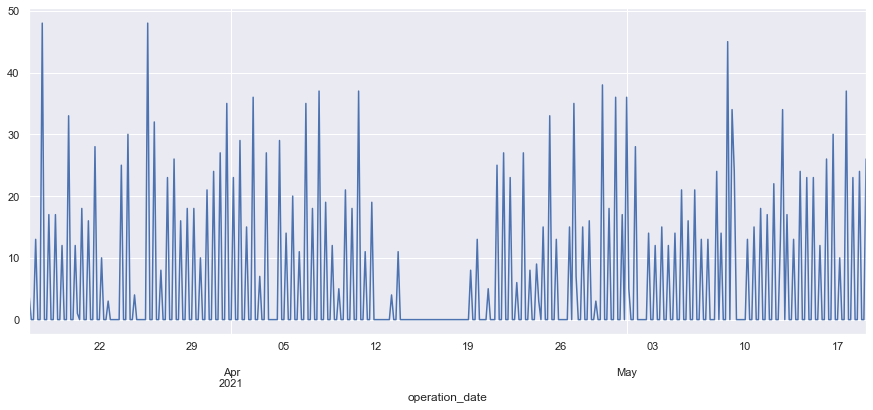

In [21]:
# Посмотрим на график отправлений

import matplotlib.pyplot as plt
%matplotlib inline

df0['quantity'].plot(figsize=(15, 6))
plt.show()

# Арима

### Для начала попробуем сделать предсказание отправления вагонов по одной станции по одному направлению

In [22]:
from statsmodels.tsa.arima_process import ArmaProcess
simulated_ARMA_data = ArmaProcess()

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from tqdm import tqdm

In [24]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df0.quantity)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
  2%|▏         | 1/64 [00:00<00:10,  5.97it/s]C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
  3%|▎         | 2/64 [00:00<00:11,  5.29it/s]C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model

,"(p, d, q)",AIC
0,"(2, 1, 3)",2640.261706
1,"(3, 1, 3)",2641.764165
2,"(2, 1, 4)",2642.225028
3,"(4, 1, 3)",2643.135305
4,"(2, 1, 5)",2643.755878
...,...,...
59,"(1, 1, 2)",2843.986683
60,"(1, 1, 1)",2860.253146
61,"(0, 1, 1)",2890.894680
62,"(1, 1, 0)",3120.211022


In [26]:
# Не сходится

best_model = SARIMAX(df0.quantity, order=(2, 1, 3)).fit()
print(best_model.summary())

C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  382
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1314.131
Date:                Fri, 04 Jun 2021   AIC                           2640.262
Time:                        00:35:11   BIC                           2663.919
Sample:                    03-16-2021   HQIC                          2649.648
                         - 05-19-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9980      0.010    -98.060      0.000      -1.018      -0.978
ar.L2         -0.9973      0.003   -292.353      0.000      -1.004      -0.991
ma.L1         -0.0189      0.055     -0.344      0.7

C:\Users\vagary\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


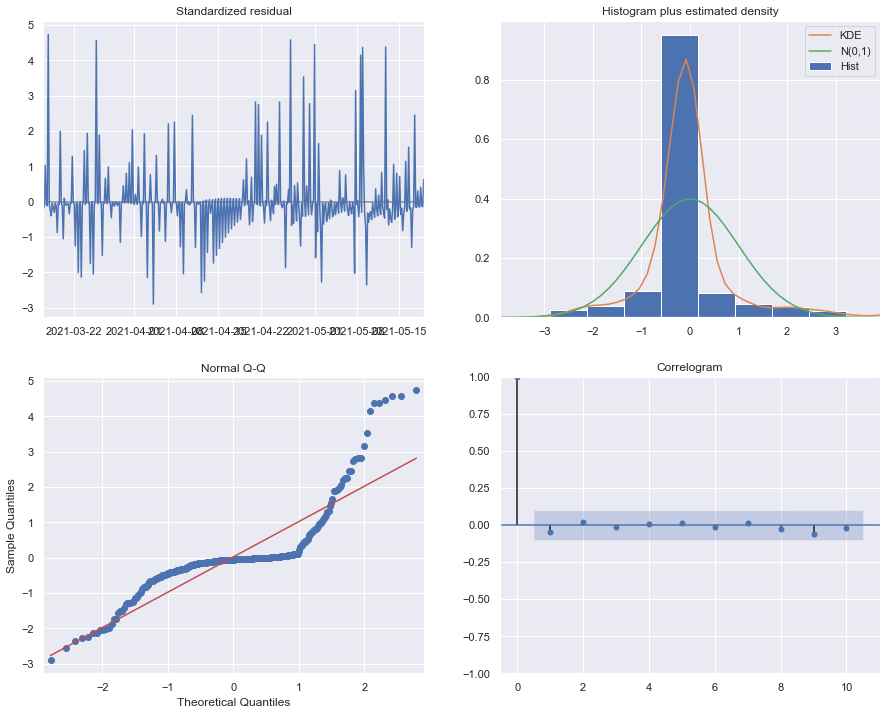

In [27]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

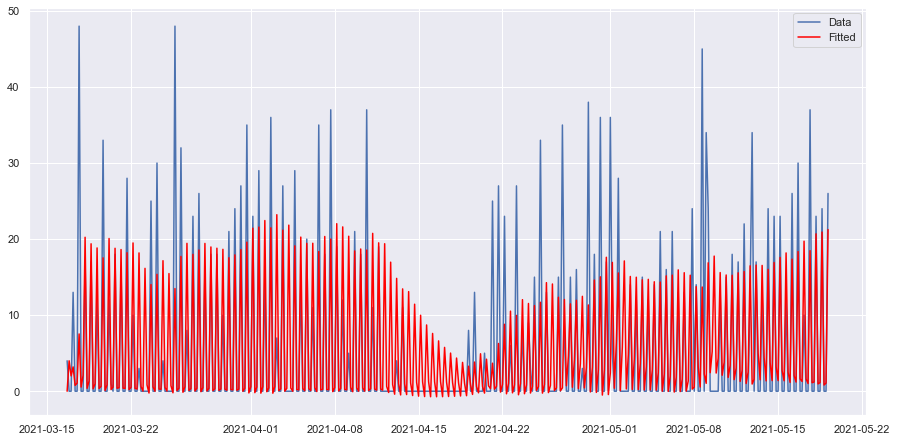

In [28]:
# Все плохо ) Арима не фитится, так как нет тренда и сезонности. Сильно сглаживает ряд

plt.figure(figsize=[15, 7.5])
plt.plot(df0.index, df0.quantity, label='Data')
plt.plot(df0.index, best_model.fittedvalues, color='red', label='Fitted')
plt.legend();

In [29]:
df0['quantity'] = df0['quantity'].replace(0.01, 0)  

C:\Users\vagary\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# LSTM на временном ряде - тоже не получается. 
# Модель отталкивается от последнего значения в ряде и сглаживает результирующие показатели

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

In [31]:
df_features1 = df0
df_features1

,quantity
operation_date,
2021-03-16 16:00:00,4.0
2021-03-16 20:00:00,0.0
2021-03-17 00:00:00,0.0
2021-03-17 04:00:00,13.0
2021-03-17 08:00:00,0.0
...,...
2021-05-18 12:00:00,0.0
2021-05-18 16:00:00,24.0
2021-05-18 20:00:00,0.0


In [32]:
train=df_features1[:250]
test=df_features1[250:]

scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [33]:
# Определяем, на каком количестве точек делаем предсказание - в данном случае на всем train

n_input=len(train)-1
n_features=1

In [34]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_generator=TimeseriesGenerator(scaled_train,
                                     scaled_train,
                                      n_input,
                                      batch_size=1)

In [35]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))

In [36]:
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 249, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 249, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(train_generator,epochs=15)

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 0.0214
Epoch 2/15
1/1 [==============================] - 0s 416ms/step - loss: 0.0200
Epoch 3/15
1/1 [==============================] - 0s 415ms/step - loss: 0.0184
Epoch 4/15
1/1 [==============================] - 0s 400ms/step - loss: 0.0168
Epoch 5/15
1/1 [==============================] - 0s 446ms/step - loss: 0.0151
Epoch 6/15
1/1 [==============================] - 1s 579ms/step - loss: 0.0133
Epoch 7/15
1/1 [==============================] - 1s 503ms/step - loss: 0.0114
Epoch 8/15
1/1 [==============================] - 0s 478ms/step - loss: 0.0094
Epoch 9/15
1/1 [==============================] - 0s 457ms/step - loss: 0.0073
Epoch 10/15
1/1 [==============================] - 0s 463ms/step - loss: 0.0052
Epoch 11/15
1/1 [==============================] - 0s 438ms/step - loss: 0.0030
Epoch 12/15
1/1 [==============================] - 0s 448ms/step - loss: 0.0011
Epoch 13/15
1/1 [==============================] - 0

In [38]:
test_predictions = []

# Выбираем последние n_input значений из train
first_eval_batch = scaled_train[-n_input:]

# Делаем reshape для LSTM (#batch, #timesteps, #features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)

    current_batch = np.append(current_batch[:,1:,:],
                          [[pred]],
                          axis=1)

In [39]:
actual_predictions = scaler.inverse_transform(test_predictions)
actual_predictions

array([[ 9.34953475],
       [ 9.38716221],
       [ 9.43167543],
       [ 9.47902751],
       [ 9.52643037],
       [ 9.57206297],
       [ 9.61481881],
       [ 9.65411067],
       [ 9.68971395],
       [ 9.7216444 ],
       [ 9.75007224],
       [ 9.7752564 ],
       [ 9.79750156],
       [ 9.81711745],
       [ 9.83441806],
       [ 9.84968805],
       [ 9.86319423],
       [ 9.87517047],
       [ 9.88582492],
       [ 9.89533854],
       [ 9.90386724],
       [ 9.91154552],
       [ 9.91848922],
       [ 9.92479205],
       [ 9.93054128],
       [ 9.93580198],
       [ 9.94063711],
       [ 9.94509673],
       [ 9.94922233],
       [ 9.95305181],
       [ 9.95661592],
       [ 9.95994115],
       [ 9.96305108],
       [ 9.96596575],
       [ 9.9687016 ],
       [ 9.97127652],
       [ 9.97369909],
       [ 9.97598433],
       [ 9.97814155],
       [ 9.98018003],
       [ 9.98210835],
       [ 9.98393369],
       [ 9.98566318],
       [ 9.98730111],
       [ 9.98885393],
       [ 9

In [40]:
test.tail(10)

,quantity
operation_date,
2021-05-17 16:00:00,37.0
2021-05-17 20:00:00,0.0
2021-05-18 00:00:00,0.0
2021-05-18 04:00:00,23.0
2021-05-18 08:00:00,0.0
2021-05-18 12:00:00,0.0
2021-05-18 16:00:00,24.0
2021-05-18 20:00:00,0.0
2021-05-19 00:00:00,0.0


# XGBoost - предсказание не по временному ряду


### Для предсказания берем только дату, количество вагонов, номер станции 
### отправления и станции назначения, так как на практике для предсказания 
### на будущую дату у нас будут только эти признаки

## Сгенерируем новые фичи

In [41]:
# Вынесем фичи из дат

df_features = (
                df0
                .assign(hour = df0.index.hour)
                .assign(day = df0.index.day)
#                .assign(month = df0.index.month) - не нужен
                .assign(day_of_week = df0.index.dayofweek)
#                .assign(week_of_year = df0.index.week) - не нужен
              )

In [42]:
df_features

,quantity,hour,day,day_of_week
operation_date,,,,
2021-03-16 16:00:00,4.0,16,16,1
2021-03-16 20:00:00,0.0,20,16,1
2021-03-17 00:00:00,0.0,0,17,2
2021-03-17 04:00:00,13.0,4,17,2
2021-03-17 08:00:00,0.0,8,17,2
...,...,...,...,...
2021-05-18 12:00:00,0.0,12,18,1
2021-05-18 16:00:00,24.0,16,18,1
2021-05-18 20:00:00,0.0,20,18,1


In [43]:
# Импортируем праздничные дни, они были в периоде (но особо не влияют на прогноз)

import holidays

ru_holidays = holidays.RU()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in ru_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))


df_features = add_holiday_col(df_features, ru_holidays)
df_features

,quantity,hour,day,day_of_week,is_holiday
operation_date,,,,,
2021-03-16 16:00:00,4.0,16,16,1,0
2021-03-16 20:00:00,0.0,20,16,1,0
2021-03-17 00:00:00,0.0,0,17,2,0
2021-03-17 04:00:00,13.0,4,17,2,0
2021-03-17 08:00:00,0.0,8,17,2,0
...,...,...,...,...,...
2021-05-18 12:00:00,0.0,12,18,1,0
2021-05-18 16:00:00,24.0,16,18,1,0
2021-05-18 20:00:00,0.0,20,18,1,0


In [44]:
df_features['is_holiday'].value_counts()

0    370
1     12
Name: is_holiday, dtype: int64

### One-hot encoding ухудшает результат
### Нормализация ухудшает результат

In [45]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2

X = df_features.drop(['quantity'], axis=1)
y = df_features.quantity.values


val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)


In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb

In [47]:
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

In [48]:
xgb_model_mpg = xgb.XGBRegressor(max_depth= 40, learning_rate=0.01, n_estimators=4000, silent=True, objective='reg:linear', booster='gbtree', subsample= 0.6, colsample_bytree= 0.9, colsample_bylevel= 1, reg_lambda= 20 , random_state=42 , seed= 1, importance_type='gain')

xgb_model_mpg.fit(X_train , y_train , eval_set= [(X_val , y_val )], eval_metric= xgb_mape, early_stopping_rounds= 200)

[00:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:11.73749	validation_0-mape:0.63178
[1]	validation_0-rmse:11.69925	validation_0-mape:0.62983
[2]	validation_0-rmse:11.66708	validation_0-mape:0.62831
[3]	validation_0-rmse:11.63612	validation_0-mape:0.62529
[4]	validation_0-rmse:11.59710	validation_0-mape:0.62317
[5]	validation_0-rmse:11.56561	validation_0-mape:0.62103
[6]	validation_0-rmse:11.53579	validation_0-mape:0.61929
[7]	validation_0-rmse:11.50622	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=40,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4000, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0,
             reg_lambda=20, scale_pos_weight=1, seed=1, silent=True,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
prediction = xgb_model_mpg.predict(X_test, ntree_limit=xgb_model_mpg.best_ntree_limit)

In [51]:
prediction[prediction < 0] = 0
np.round(prediction, 0)

array([ 2., 21.,  1.,  1., 12.,  1.,  1., 20.,  1.,  1., 11.,  1.,  1.,
       19.,  1.,  0.,  8.,  0.,  0., 17.,  0.,  0.,  8.,  0.,  0., 12.,
        0.,  0.,  8.,  0.,  0., 16.,  0.,  0.,  8.,  0.,  0., 15.,  0.,
        0.,  8.,  0.,  0., 14.,  0.,  0.,  7.,  0.,  0., 13.,  0.,  0.,
        6.,  0.,  0., 13.,  0.,  0.,  4.,  0.,  0., 12.,  0.,  0.,  6.,
        0.,  0.,  9.,  0.,  0.,  7.,  0.,  0., 14.,  0.,  1., 13.],
      dtype=float32)

In [52]:
import sklearn

sklearn.metrics.mean_absolute_error(y_test, prediction, sample_weight=None, multioutput='uniform_average')

5.137897339153599

In [53]:
y_test

array([ 0., 13.,  0.,  0., 13.,  0.,  0.,  0., 24.,  0., 14.,  0.,  0.,
       45.,  0., 34., 24.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0., 15.,
        0.,  0., 18.,  0.,  0., 17.,  0.,  0., 22.,  0.,  0., 13., 34.,
        0., 17.,  0.,  0., 13.,  0.,  0., 24.,  0.,  0., 23.,  0.,  0.,
       23.,  0.,  0., 12.,  0.,  0., 26.,  0.,  0., 30.,  0.,  0., 10.,
        0.,  0., 37.,  0.,  0., 23.,  0.,  0., 24.,  0.,  0., 26.])

# Catboost

In [54]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [55]:
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

In [56]:
catboost = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=10, l2_leaf_reg=6)
# попытка убрать отриц предсказания
# catboost.fit(X_train, np.log(y_train + 1))
# prediction = np.exp(catboost.predict(X_test)) - 1
catboost.fit(X_train, y_train )
prediction = catboost.predict(X_test)

0:	learn: 10.2537915	total: 149ms	remaining: 3m 43s
1:	learn: 10.2223721	total: 151ms	remaining: 1m 53s
2:	learn: 10.1914151	total: 152ms	remaining: 1m 15s
3:	learn: 10.1718308	total: 153ms	remaining: 57.1s
4:	learn: 10.1473851	total: 154ms	remaining: 46.1s
5:	learn: 10.1190364	total: 155ms	remaining: 38.7s
6:	learn: 10.0910080	total: 156ms	remaining: 33.3s
7:	learn: 10.0522985	total: 157ms	remaining: 29.3s
8:	learn: 10.0224497	total: 159ms	remaining: 26.3s
9:	learn: 9.9827973	total: 160ms	remaining: 23.8s
10:	learn: 9.9548633	total: 161ms	remaining: 21.8s
11:	learn: 9.9265823	total: 162ms	remaining: 20.1s
12:	learn: 9.8989335	total: 163ms	remaining: 18.6s
13:	learn: 9.8787639	total: 166ms	remaining: 17.6s
14:	learn: 9.8354078	total: 166ms	remaining: 16.5s
15:	learn: 9.8034456	total: 168ms	remaining: 15.6s
16:	learn: 9.7738520	total: 170ms	remaining: 14.9s
17:	learn: 9.7533599	total: 172ms	remaining: 14.1s
18:	learn: 9.7255892	total: 172ms	remaining: 13.4s
19:	learn: 9.6940292	total: 1

In [57]:
import sklearn

sklearn.metrics.mean_absolute_error(y_test, prediction, sample_weight=None, multioutput='uniform_average')

5.7239575349195295

In [58]:
from sklearn.model_selection import RandomizedSearchCV

catboost = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=10, l2_leaf_reg=6, loss_function='MAE')

iterations = [1000, 1500, 2000]
lr = [x for x in np.linspace(start=0.01, stop=0.3, num=30)]
loss = ['MAE']
depth = [int(x) for x in np.linspace(start=1, stop=50, num=10)]
l2_leaf = [x for x in np.linspace(start=1, stop=10)]

random_grid= {
'iterations': iterations
, 'learning_rate': lr
, 'depth': depth
, 'l2_leaf_reg' : l2_leaf
, 'loss_function' : loss
}

catboost_random = RandomizedSearchCV(estimator=catboost, param_distributions=random_grid)

In [59]:
catboost_random.fit(X_train, y_train )
prediction = catboost_random.predict(X_test)

0:	learn: 4.9560439	total: 1.04ms	remaining: 1.55s
1:	learn: 4.8159339	total: 1.89ms	remaining: 1.42s
2:	learn: 4.5956042	total: 2.71ms	remaining: 1.35s
3:	learn: 4.4126207	total: 3.73ms	remaining: 1.39s
4:	learn: 4.4126207	total: 4.41ms	remaining: 1.32s
5:	learn: 4.4126206	total: 4.81ms	remaining: 1.2s
6:	learn: 4.4126206	total: 5.57ms	remaining: 1.19s
7:	learn: 4.3233613	total: 7.15ms	remaining: 1.33s
8:	learn: 4.3233612	total: 8.02ms	remaining: 1.33s
9:	learn: 4.3233612	total: 8.89ms	remaining: 1.32s
10:	learn: 4.2497348	total: 9.73ms	remaining: 1.32s
11:	learn: 4.0485084	total: 10.6ms	remaining: 1.31s
12:	learn: 3.9625574	total: 11.4ms	remaining: 1.3s
13:	learn: 3.9625573	total: 12.2ms	remaining: 1.3s
14:	learn: 3.9625573	total: 13ms	remaining: 1.29s
15:	learn: 3.6773847	total: 14.3ms	remaining: 1.32s
16:	learn: 3.6773847	total: 14.9ms	remaining: 1.3s
17:	learn: 3.5749167	total: 16ms	remaining: 1.32s
18:	learn: 3.4928958	total: 17.1ms	remaining: 1.33s
19:	learn: 3.4928958	total: 17

In [60]:
catboost_random.best_params_

{'loss_function': 'MAE',
 'learning_rate': 0.09999999999999998,
 'l2_leaf_reg': 6.510204081632653,
 'iterations': 1500,
 'depth': 6}

In [61]:
catboost_random.best_score_

0.08260170159292982

In [62]:
catboost_best = CatBoostRegressor(loss_function= 'MAE',
 learning_rate= 0.03,
 l2_leaf_reg=8.89795918367347,
 iterations= 1500,
 depth= 6)
catboost_best.fit(X_train, y_train )
prediction = catboost_best.predict(X_test)

0:	learn: 5.2149123	total: 766us	remaining: 1.15s
1:	learn: 5.1838595	total: 1.81ms	remaining: 1.36s
2:	learn: 5.1292542	total: 2.76ms	remaining: 1.38s
3:	learn: 5.0558568	total: 3.65ms	remaining: 1.36s
4:	learn: 5.0558568	total: 4.56ms	remaining: 1.36s
5:	learn: 4.9994982	total: 5.57ms	remaining: 1.39s
6:	learn: 4.9679509	total: 6.55ms	remaining: 1.4s
7:	learn: 4.9679508	total: 7.52ms	remaining: 1.4s
8:	learn: 4.8684743	total: 8.46ms	remaining: 1.4s
9:	learn: 4.8684743	total: 9.57ms	remaining: 1.43s
10:	learn: 4.7652321	total: 10.5ms	remaining: 1.43s
11:	learn: 4.7235756	total: 11.6ms	remaining: 1.43s
12:	learn: 4.7235756	total: 12.2ms	remaining: 1.39s
13:	learn: 4.7235756	total: 13ms	remaining: 1.38s
14:	learn: 4.6871674	total: 14ms	remaining: 1.38s
15:	learn: 4.6474411	total: 14.9ms	remaining: 1.38s
16:	learn: 4.6017012	total: 15.9ms	remaining: 1.38s
17:	learn: 4.5500248	total: 16.8ms	remaining: 1.39s
18:	learn: 4.4979127	total: 17.7ms	remaining: 1.38s
19:	learn: 4.4979127	total: 18

In [63]:
sklearn.metrics.mean_absolute_error(y_test, prediction, sample_weight=None, multioutput='uniform_average')

6.127435646446345

In [64]:
np.round(prediction, 0)

array([ 0., 28.,  0.,  0., 12.,  0.,  0., 26.,  0.,  0., 10., -0.,  0.,
       24., -0.,  0.,  8., -0., -0., 24., -0.,  0.,  5.,  0.,  0.,  9.,
       -0., -0.,  4., -0., -0., 15., -0., -0.,  4., -0., -0., 12., -0.,
        0.,  4.,  0.,  0.,  7.,  0., -0.,  0.,  0., -0.,  2., -1., -0.,
        3.,  0., -0.,  3., -1., -0.,  1.,  0.,  0.,  2., -1.,  0.,  6.,
        0.,  0.,  7., -0.,  0.,  6., -0.,  0., 14., -0., -0., 16.])

In [65]:
y_test

array([ 0., 13.,  0.,  0., 13.,  0.,  0.,  0., 24.,  0., 14.,  0.,  0.,
       45.,  0., 34., 24.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0., 15.,
        0.,  0., 18.,  0.,  0., 17.,  0.,  0., 22.,  0.,  0., 13., 34.,
        0., 17.,  0.,  0., 13.,  0.,  0., 24.,  0.,  0., 23.,  0.,  0.,
       23.,  0.,  0., 12.,  0.,  0., 26.,  0.,  0., 30.,  0.,  0., 10.,
        0.,  0., 37.,  0.,  0., 23.,  0.,  0., 24.,  0.,  0., 26.])

## Сделаем предсказания по одной станции отправления по всем парам "станция отправления - станция назначения" на основе предсказаний XGBoost и посмотрим среднюю ошибку MAE

In [66]:
# Каждая пара должна учиться на своих данных --> модель надо обучать отдельно для каждой пары

# можно брать из датасета выборку по станции отправления, в этой выборке циклом пройтись по станциям назначения 
# ответ записать в таблицу csv / либо по каждой станции отправления записать предсказания в отдельный файл

In [67]:
# Делаем по одной станции отправления и всем станциям назначения, возьмем самую загруженную

res['operation_st_esr'].value_counts()

960007    4487
943108    4344
950101    3269
951706    2952
967600    2938
          ... 
966400       1
951405       1
941403       1
953006       1
942603       1
Name: operation_st_esr, Length: 128, dtype: int64

In [68]:
dataset_960007 = res[res['operation_st_esr'] == 960007] # Комсомольск-Сортировочный, Дальневосточная ж/д

In [69]:
dataset_960007.drop(['operation_st_esr'], axis=1, inplace = True)
dataset_960007.head()

,index_train,quantity
operation_date,,
2021-05-14 20:00:00,986103,1.0
2021-03-16 04:00:00,970001,5.0
2021-03-16 08:00:00,970001,0.0
2021-03-16 12:00:00,970001,0.0
2021-03-16 16:00:00,970001,0.0


In [70]:
# По некоторым направлениям было отправлено по 1 вагону

dataset_960007['index_train'].value_counts()

970001    386
968707    383
917207    381
890201    380
917103    379
950101    374
920002    358
965501    355
960103    352
918905    343
862108    317
913206    282
965107    181
985505     13
913102      1
986103      1
966504      1
Name: index_train, dtype: int64

In [71]:
trains =  dataset_960007['index_train'].unique() # кол-во направлений отправлений поездов
len(trains)

17

In [72]:
dates = pd.date_range('2021-03-16 00:00:00', '2021-05-20 05:51:00', freq = '4H')
dates

DatetimeIndex(['2021-03-16 00:00:00', '2021-03-16 04:00:00',
               '2021-03-16 08:00:00', '2021-03-16 12:00:00',
               '2021-03-16 16:00:00', '2021-03-16 20:00:00',
               '2021-03-17 00:00:00', '2021-03-17 04:00:00',
               '2021-03-17 08:00:00', '2021-03-17 12:00:00',
               ...
               '2021-05-18 16:00:00', '2021-05-18 20:00:00',
               '2021-05-19 00:00:00', '2021-05-19 04:00:00',
               '2021-05-19 08:00:00', '2021-05-19 12:00:00',
               '2021-05-19 16:00:00', '2021-05-19 20:00:00',
               '2021-05-20 00:00:00', '2021-05-20 04:00:00'],
              dtype='datetime64[ns]', length=392, freq='4H')

In [73]:
pd_dates = pd.DataFrame(index= dates)
pd_dates

""
2021-03-16 00:00:00
2021-03-16 04:00:00
2021-03-16 08:00:00
2021-03-16 12:00:00
2021-03-16 16:00:00
...
2021-05-19 12:00:00
2021-05-19 16:00:00
2021-05-19 20:00:00
2021-05-20 00:00:00


In [77]:
# Заполним нулями количество вагонов, когда отправок по какому-либо из направлений не было
# Другими словами, заполним пропуски

def fill_0(new_data):
    
    trial = pd.merge(pd_dates, new_data, how='left', left_index = True, right_index = True) 
    trial.fillna(0, inplace = True)
    return trial

In [78]:
%%time

def make_features(df):
    df_features = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
#                .assign(month = df.index.month) - не нужен
                .assign(day_of_week = df.index.dayofweek)
#                .assign(week_of_year = df.index.week) - не нужен
              )    
    return df_features


def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

def split(X, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return(X_train, X_test, y_train, y_test, X_val, y_val)


def make_prediction(X_train, X_test, y_train, y_test, X_val, y_val):

    xgb_model_mpg = xgb.XGBRegressor(max_depth= 40, learning_rate=0.01, n_estimators=4000, silent=True, objective='reg:linear', booster='gbtree', subsample= 0.6, colsample_bytree= 0.9, colsample_bylevel= 1, reg_lambda= 20 , random_state=42 , seed= 1, importance_type='gain')
    xgb_model_mpg.fit(X_train , y_train , eval_set= [(X_val , y_val )], eval_metric= xgb_mape, early_stopping_rounds= 200)
    
    prediction = xgb_model_mpg.predict(X_test, ntree_limit=xgb_model_mpg.best_ntree_limit)
    
    prediction[prediction < 0] = 0
    prediction = np.round(prediction, 0)
    
 #   MAE_val = sklearn.metrics.mean_absolute_error(y_test, prediction, sample_weight=None, multioutput='uniform_average')
    
    return prediction


test_ratio = 0.2
MAE_list = []
total_pred = pd.DataFrame([])

for i in trains: 
    
    dataset_i = dataset_960007[dataset_960007['index_train'] == i]
    
    dataset_i = fill_0(dataset_i)

    dataset_i = make_features(dataset_i)
    
    X = dataset_i.drop(['quantity', 'index_train'], axis=1)
    y = dataset_i.quantity.values
        
    X_train, X_test, y_train, y_test, X_val, y_val = split(X, y, test_ratio)
    
    test_dates = dates[-len(y_test):]
    
    prediction = make_prediction(X_train, X_test, y_train, y_test, X_val, y_val)
        
    MAE_val = sklearn.metrics.mean_absolute_error(y_test, prediction, sample_weight=None, multioutput='uniform_average')
    MAE_list.append(MAE_val)
    
    total_pred[i] = prediction
    

total_pred

[00:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[00:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.49563	validation_0-mape:0.49563
[1]	validation_0-rmse:0.49129	validation_0-mape:0.49129
[2]	validation_0-rmse:0.48698	validation_0-mape:0.48698
[3]	validation_0-rmse:0.48269	validation_0-mape:0.48269
[4]	validation_0-rmse:0.47846	validation_0-mape:0.47846
[5]	validation_0-rmse:0.47426	validation_0-mape:0.47426
[6]	validation_0-rmse:0.47012	validation_0-mape:0.47012
[7]	validation_0-rmse:0.46598	validation_0-ma

,986103,970001,950101,920002,862108,890201,985505,917207,917103,968707,918905,965501,960103,913206,965107,966504,913102
0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
total_pred.index = test_dates
total_pred

,986103,970001,950101,920002,862108,890201,985505,917207,917103,968707,918905,965501,960103,913206,965107,966504,913102
2021-05-07 04:00:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 08:00:00,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 12:00:00,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 16:00:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 20:00:00,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19 12:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-19 16:00:00,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-19 20:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-20 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
MAE_list

[0.012658227848101266,
 2.151898734177215,
 1.0,
 0.02531645569620253,
 0.012658227848101266,
 0.3924050632911392,
 0.0,
 1.7215189873417722,
 1.0759493670886076,
 2.088607594936709,
 0.012658227848101266,
 0.06329113924050633,
 0.10126582278481013,
 2.759493670886076,
 0.05063291139240506,
 0.0,
 0.379746835443038]

In [81]:
np.mean(MAE_list)

0.6969471332836933

In [82]:
total_pred.to_csv(f'station_N{960007}.csv', index=True)
total_pred.head(10)

,986103,970001,950101,920002,862108,890201,985505,917207,917103,968707,918905,965501,960103,913206,965107,966504,913102
2021-05-07 04:00:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 08:00:00,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 12:00:00,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 16:00:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-07 20:00:00,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-08 00:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-08 04:00:00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-08 08:00:00,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-08 12:00:00,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-08 16:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
